<a href="https://colab.research.google.com/github/GovindNairV/urban8k/blob/main/urban8k_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Audio Classifier using CNN

This is a classifier to classify UrbanSound8k dataset into 10 different classes using Convolutional Neural Network. The dataset contains 8732 sound files of 10 different classes:

* Air Conditioner
* Car Horn
* Children Playing
* Dog Bark
* Drilling Machine
* Engine Idling
* Gun Shot
* Jackhammer
* Siren
* Street Music

This lies under the supervised machine learning category, so we have a dataset as well as a target category.



## Download Dataset from Kaggle

First we install the required library

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<br>We are using the opendatasets library to download the dataset from kaggle. To properly download the dataset follow the following steps:

1. Create an account in www.kaggle.com
2. Go to your profile and click on account. 
<img src = "https://media.geeksforgeeks.org/wp-content/uploads/20220511164639/Capture9.PNG"  height = 450>

3. On the following page you will see an API section, where you will find a “Create New API Token” click on it, and it will download a kaggle.json file in which you will get your username and key.
4. Upload the kaggle.json file to <b>/content</b> directory (the directory which is open by default when you open colab).
5. Run the cell below.

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/chrisfilo/urbansound8k")

100%|██████████| 5.61G/5.61G [00:52<00:00, 115MB/s]


# Preparing the data

### Import all the required libraries and packages

In [ ]:
import os
import pandas as pd
import librosa 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import IPython.display as idp
from tensorflow.keras.models import load_model
import cv2
import warnings
warnings.simplefilter("ignore")
from sklearn.metrics import classification_report,confusion_matrix

### Data Preprocessing

In [ ]:
audio_dataset_path = '/content/urbansound8k'
df = pd.read_csv('/content/urbansound8k/UrbanSound8K.csv')

In [ ]:
df.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
classes = df['class'].unique()
print("Classes are: ",classes)
print("# of Classes are: ",classes.shape[0])

Classes are:  ['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']
# of Classes are:  10


Now we will use Librosa to load audio data. So when we load any audio file with Librosa, it gives us 2 things. One is sample rate, and the other is a two-dimensional array. Let us load the above audio files with Librosa.

* Sample rate – It represents how many samples are recorded per second. The default sampling rate with which librosa reads the file is 22050. The sample rate differs by the library you choose.
* 2-D Array – The first axis represents recorded samples of amplitude. And the second axis represents the number of channels. There are different types of channels – Monophonic(audio that has one channel) and stereo(audio that has two channels).

<br>We will use the librosa library to calculate the MFCC of each audio file that is loaded. The MFCC summarizes the frequency distribution across the window size. So, it is possible to analyze both the frequency and time characteristics of the sound. This audio representation will allow us to identify features for classification. So, it will try to convert audio into some kind of features based on time and frequency characteristics that will help us to do classification.

In [ ]:
X = []
y = []
up_width = 173
up_height = 40
for data in df.iterrows():
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(data[1][5])+'/',str(data[1][0]))
    raw , sr = librosa.load(file_name, res_type='kaiser_fast')
    X_ = librosa.feature.mfcc(y=raw, sr=sr, n_mfcc=40)
    up_points = (up_width, up_height)
    X_ = cv2.resize(X_, up_points, interpolation= cv2.INTER_LINEAR)
    X.append(X_)
    y.append(data[1][7])

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
print(X.shape)
print(y.shape)

(8732, 40, 173)
(8732,)


In [ ]:
y = to_categorical(le.fit_transform(y))
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [ ]:
print("X Shape is: ", X.shape)
print("y Shape is: ", y.shape)

X Shape is:  (8732, 40, 173, 1)
y Shape is:  (8732, 10)


### Train Test Split

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)

In [ ]:
INPUTSHAPE = (up_height,up_width,1)

# Model Building

In [ ]:
model =  models.Sequential([    
                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),  
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(256 , activation = 'relu'),
                          layers.Dense(10 , activation = 'softmax')
])

opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = 'acc')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 171, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 84, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 128)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 9, 42, 128)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 40, 128)        1

# Model Training

In [ ]:
batch_size = 8
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

history = model.fit(X_train,y_train ,
            validation_data=(X_test,y_test),
            epochs=15,
            callbacks = [callback],batch_size=batch_size)

Epoch 1/15
874/874 [==============================] - 147s 167ms/step - loss: 1.4218 - acc: 0.4932 - val_loss: 1.0480 - val_acc: 0.6388
Epoch 2/15
874/874 [==============================] - 136s 155ms/step - loss: 0.9145 - acc: 0.6833 - val_loss: 0.7889 - val_acc: 0.7218
Epoch 3/15
874/874 [==============================] - 134s 154ms/step - loss: 0.6953 - acc: 0.7639 - val_loss: 0.5356 - val_acc: 0.8248
Epoch 4/15
874/874 [==============================] - 134s 154ms/step - loss: 0.5532 - acc: 0.8096 - val_loss: 0.5561 - val_acc: 0.8065
Epoch 5/15
874/874 [==============================] - 134s 153ms/step - loss: 0.4764 - acc: 0.8395 - val_loss: 0.4381 - val_acc: 0.8552
Epoch 6/15
874/874 [==============================] - 135s 155ms/step - loss: 0.3875 - acc: 0.8689 - val_loss: 0.4250 - val_acc: 0.8649
Epoch 7/15
874/874 [==============================] - 134s 153ms/step - loss: 0.3368 - acc: 0.8809 - val_loss: 0.4101 - val_acc: 0.8620
Epoch 8/15
874/874 [============================

# Model Accuracy & Loss

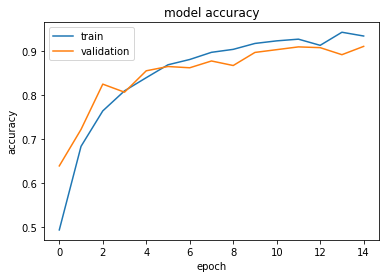

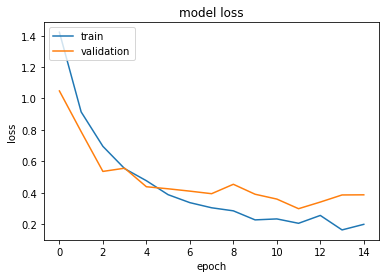

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Evaluation ✅

In [ ]:
Y_pred = model.predict(X_test)
Y_pred = [np.argmax(i) for i in Y_pred]
y_test = [np.argmax(i) for i in y_test]

55/55 [==============================] - 8s 145ms/step


In [ ]:
print(classification_report(y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       203
           1       0.92      0.94      0.93        86
           2       0.82      0.90      0.86       183
           3       0.95      0.82      0.88       201
           4       0.93      0.93      0.93       206
           5       0.97      0.93      0.95       193
           6       0.88      0.94      0.91        72
           7       0.96      0.91      0.94       208
           8       0.88      0.98      0.92       165
           9       0.90      0.86      0.88       230

    accuracy                           0.91      1747
   macro avg       0.91      0.92      0.91      1747
weighted avg       0.91      0.91      0.91      1747



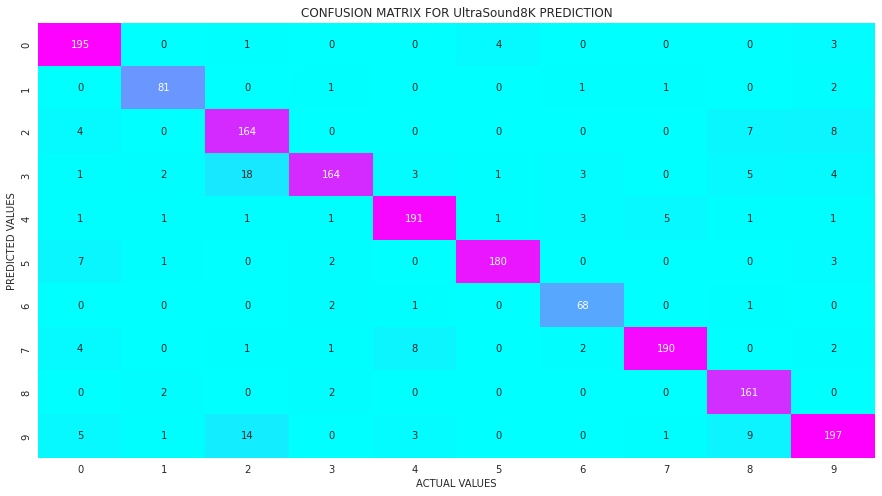

In [ ]:
sns.set_style("dark")
plt.figure(figsize=(15,8))
plt.title("CONFUSION MATRIX FOR UrbanSound8K PREDICTION")
cm = confusion_matrix([int(x) for x in y_test],Y_pred)
sns.heatmap(cm, annot=True, cmap="cool", fmt='g', cbar=False)
plt.xlabel("ACTUAL VALUES")
plt.ylabel("PREDICTED VALUES")
plt.show()